In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import darc
from darc.delayed import models
from darc.designs import DARCDesign

from darc.data_plotting import plot_delay_without_front_end_delays
from darc_parameter_recovery import simulated_experiment_trial_loop

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Simulated experiment with `DelaySlice` model

In [3]:
max_trials = 20

design_thing = DARCDesign(max_trials=max_trials,
                          RA=list(100*np.linspace(0.05, 0.95, 100)),
                          DB=[180])

model = models.DelaySlice(n_particles=5000)

# model = model.generate_faux_true_params()
indiff_true = 0.8
α_true = 0.05
model.θ_true = pd.DataFrame.from_dict({'indiff': [indiff_true], 'α': [α_true]})

fitted_model = simulated_experiment_trial_loop(design_thing, model)


/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:153: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled+n_times_sampled_iter))
/Users/btvincent/git-local/darc-experiments-python/bad/optimisation.py:226: RuntimeWarning: invalid value encountered in true_divide
  (n_times_sampled + n_times_sampled_iter))


Visualise the raw data

(0, 1)

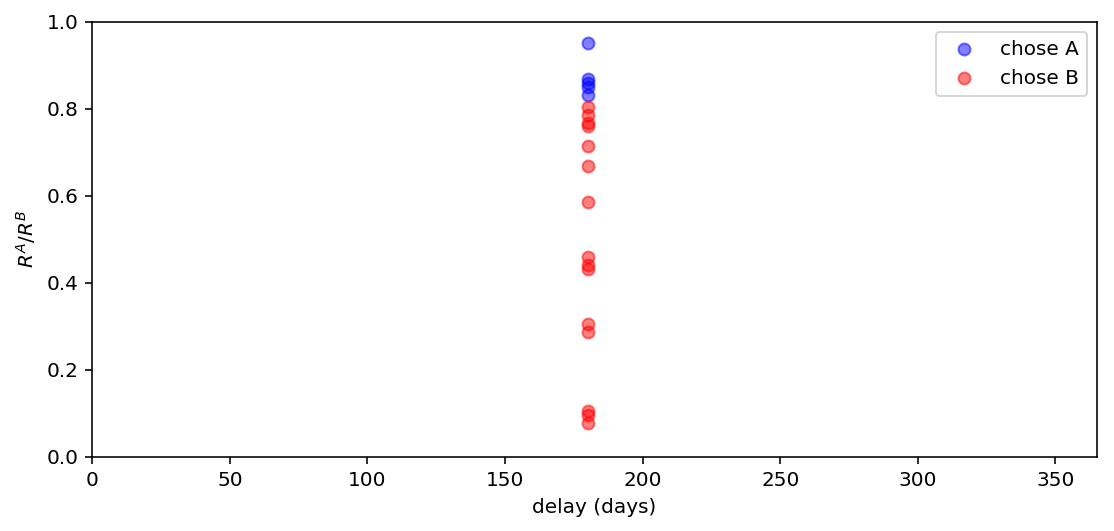

In [4]:
fig, ax = plt.subplots(figsize=(9,4))
plot_delay_without_front_end_delays(ax, design_thing.all_data)
ax.set_xlim([0, 365])
ax.set_ylim([0, 1])

## Posterior predictive checking

In [5]:
def plot_data(ax, all_data):
    x = all_data['RA'].values / all_data['RB'].values
    y = all_data['R'].values
    ax.scatter(x, y, c='k')

In [6]:
Phi = lambda x: norm.cdf(x, loc=0, scale=1)

def Psi(x, indiff, α, ϵ=0.01):
    return ϵ+(1-2*ϵ) * Phi((indiff-x)/α) # TODO: CHECK x is right way around

In [7]:
θpe = fitted_model.get_θ_point_estimate()
indiff_median = θpe['indiff'].values
α_median = θpe['α'].values

In [8]:
x = np.linspace(0, 1, 500)

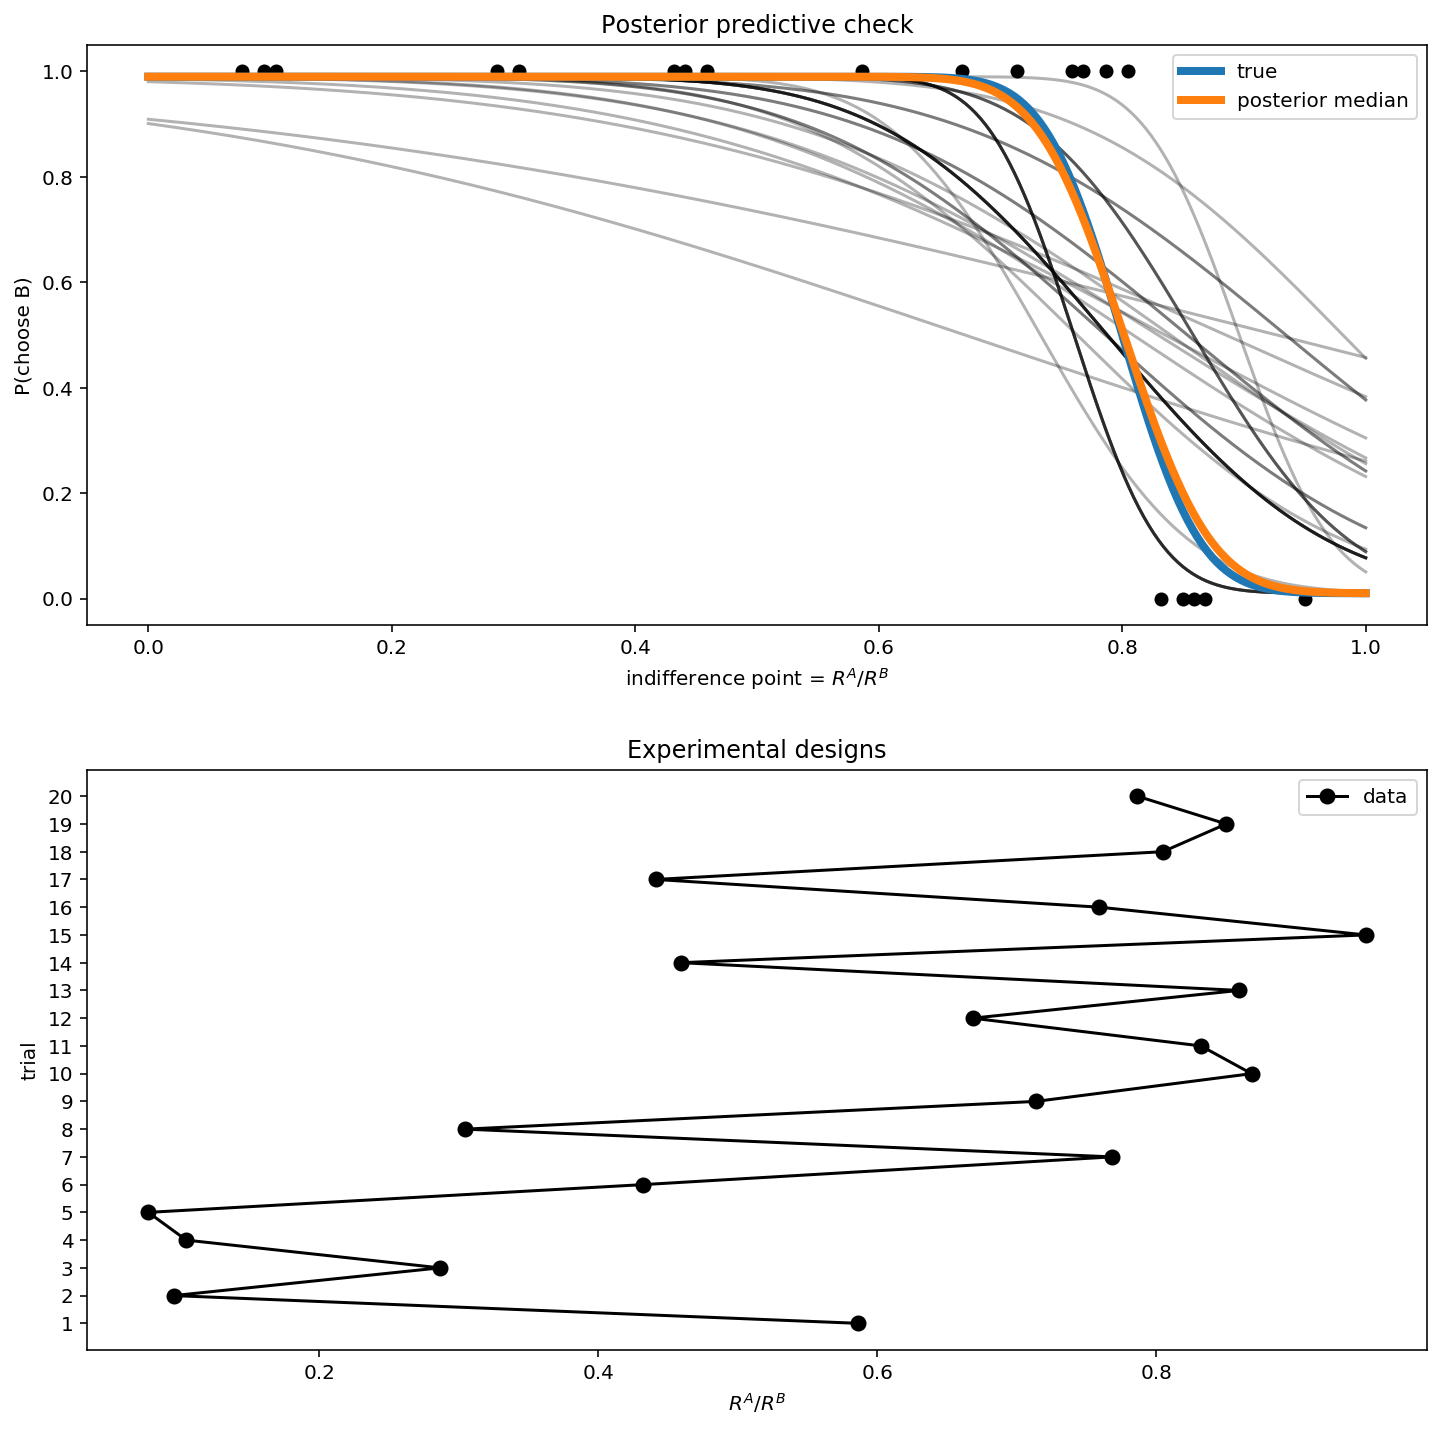

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))

# Psychometric function posterior predictive check + data ====================
XN = 500
x = np.linspace(0, 1, XN)

# plot a bunch of samples from the posterior distribution
N_SAMPLES = 50
θ = fitted_model.θ.sample(N_SAMPLES)
y = np.zeros((XN, N_SAMPLES))
for i, (indiff, α) in enumerate(zip(θ['indiff'].values, θ['α'].values)):
    y[:,i] = Psi(x, indiff, α, ϵ=0.01)
    
ax[0].plot(x, y, c='k', alpha=0.3)

# plot true psychophysical function
y = Psi(x, indiff_true, α_true, ϵ=0.01)
ax[0].plot(x, y, lw=4, label='true')

# plot posterior median
y = Psi(x, indiff_median, α_median, ϵ=0.01)
ax[0].plot(x, y, lw=4, label='posterior median')

# overlay the data onto this plot
plot_data(ax[0], design_thing.all_data)

# formatting
ax[0].set_ylim([0-0.05, 1+0.05])
ax[0].legend()

ax[0].set_xlabel('indifference point = $R^A/R^B$')
ax[0].set_ylabel('P(choose B)')
ax[0].set_title('Posterior predictive check')


# Visualise things as a function of trial ===================================

trial = np.arange(design_thing.all_data.shape[0]) + 1
indiff = design_thing.all_data['RA'].values / design_thing.all_data['RB'].values
ax[1].plot(indiff, trial, '-o', ms=7, c='k', label='data')

ax[1].set_ylabel('trial')
ax[1].set_xlabel('$R^A/R^B$')
ax[1].set_yticks(trial)
ax[1].legend()
ax[1].set_title('Experimental designs')

plt.subplots_adjust(hspace=0.25)